# <center>Лабораторна робота № 1</center>

Спочатку імпортуємо необхідні модулі та визначимо константи

In [11]:
import numpy as np
from math import floor, log
from functools import lru_cache, partial
from scipy.spatial.distance import euclidean

#для візуалізації
from mpl_toolkits import mplot3d 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from IPython.display import Image


# для перевірки обчислень
from scipy.optimize import minimize

In [2]:
h = 1e-5  #для знаходження центральної різницевої похідної
eps = 1e-10  #для визначення збіжності
lambd = 0.5  #для методу дроблення
beta = 1  #для методу дроблення
l = 1e-10 #довжина інтервалу невизначеності в методі Фібоначчі
ksi = 1e-10  #для методу Фібоначчі

### <center>Функція і знаходження градієнта чисельними методами (для будь-яких функцій багатьох змінних)

In [3]:
def f(x):
    """Функція"""
    return 3 * x[0] ** 2 + 2 * x[1] ** 2 - 0.01 * x[0] * x[1] + x[0] - x[1]


def f_alpha(alpha, x=[0], h=[0]):
    """Функція, яка потрібна для мінімізації по альфа"""
    return f(x + alpha * h)


def df(x):
    """Градієнт"""
    return np.array([(f(x + h * eye) - f(x - h * eye)) / (2 * h) for eye in np.eye(len(x))])

### <center>Побудова графіка функції 

Text(0.5,0,'f(x,y)')

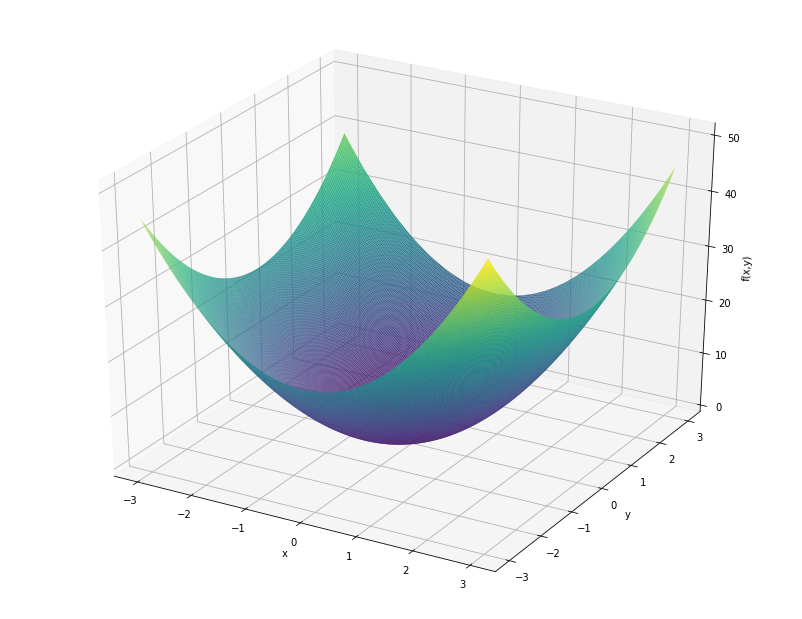

In [4]:
x = np.linspace(-3, 3, 300)
y = np.linspace(-3, 3, 300)


plt.rcParams['figure.figsize'] = (14, 11)
X, Y = np.meshgrid(x, y)
Z = f([X, Y])
fig = plt.figure()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')


In [5]:
# для самоперевірки
solution = minimize(f, np.zeros(2), method= 'L-BFGS-B').x
print(f"Мінімум досягається при х = {solution[0]}, y = {solution[1]}")


Мінімум досягається при х = -0.16625069812183513, y = 0.24958436894204078


## <center> Градієнтний метод (знаходження кроку методом дроблення)

In [6]:
def alpha_drob(x, h):
    alpha = beta
    while (f(x + alpha * h) - f(x)) >= eps ** 2:
        alpha = alpha * lambd
    return alpha    
    

In [7]:
def grad_descent_dividing(start_point=np.zeros(2), visualize=False):
    """Градієнтний метод дроблення"""
    alphas = []
    h = - df(start_point)
    x_cur = start_point
    alpha = alpha_drob(x_cur, h)
    alphas.append(alpha)
    x = x_cur + alpha * h 
    while np.linalg.norm(x - x_cur) >= eps:
        x_cur = x
        h = - df(x_cur)
        alpha = alpha_drob(x_cur, h)
        alphas.append(alpha)
        x = x_cur + alpha * h
    if visualize:
        return alphas
    return x

In [8]:
print(f"Мінімум функції досягається при x = {grad_descent_dividing()[0]}, y = {grad_descent_dividing()[1]}")

Мінімум функції досягається при x = -0.16625069301926257, y = 0.2495843732702441


In [9]:

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)

alphas = grad_descent_dividing(visualize=True)
x = np.arange(len(alphas))
trace = go.Scatter(x=x, y=alphas, mode = 'markers')   
layout = {'title': f"Dependency alpha from step"}
iplot(go.Figure(data=[trace], layout=layout), show_link=True)

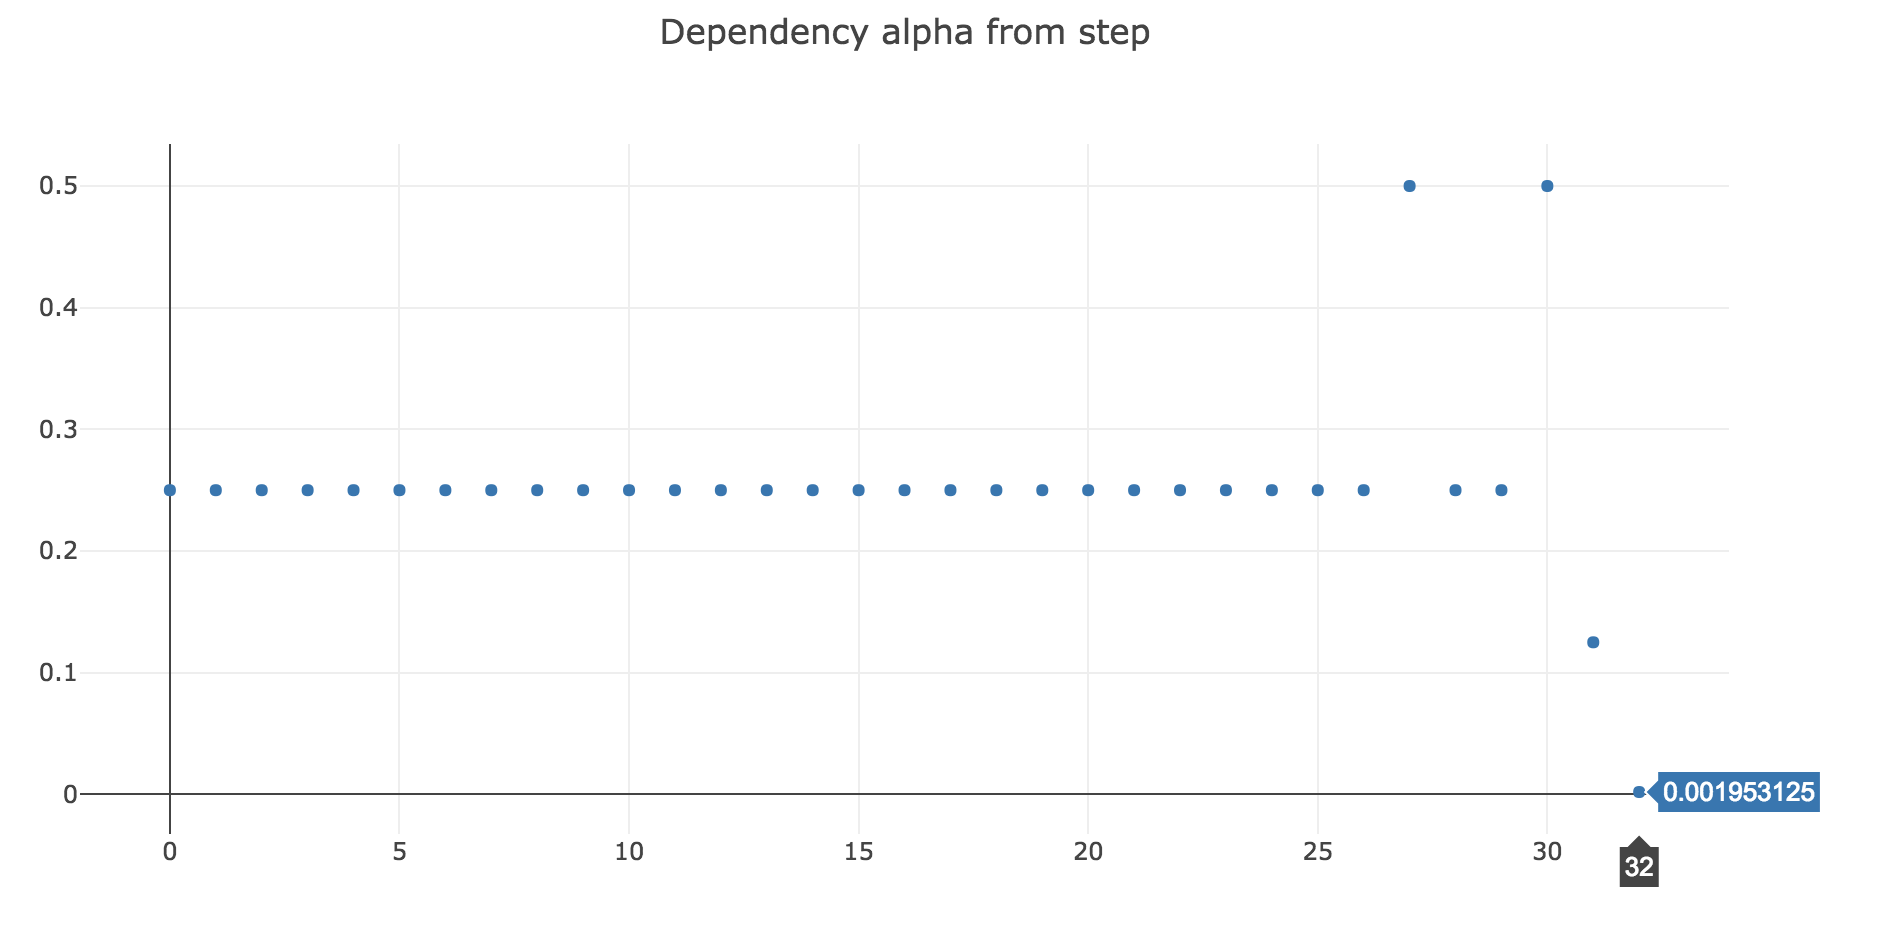

In [14]:
Image('image/grad_descent_dividing.png')

## <center> Градієнтний метод найшвидшого спуску

Обрали метод одновимірної оптимізації Фібоначчі. Для цього знадобиться дві функції: така, яка повертала б найменше  ```n```, щоб ```n```-те число Фібоначчі було більше за ```x```(для визначення числа ітерацій) та функція яка повертала б ```n```-те число Фібоначчі

In [4]:
@lru_cache(maxsize=None)
def fibonacci(index):
    """Функція, яка повертає число Фібоначчі за індексом"""
    if index < 2:
        return 1
    else:
        return fibonacci(index - 1) + fibonacci(index - 2)
    
    
def fibonacci_n(x):
    """Функція, яка повертає найменше n, таке, що F_n > x"""
    phi = (1 + 5 ** 0.5) / 2
    arg = floor(x) * 5 ** 0.5 + (5 * floor(x) ** 2 + 4) ** 0.5
    return floor(log(arg) / log(phi)) - 1

Метод Фібоначчі, який використовуватиметься для мінімізації по альфа

In [5]:
def fibonacci_optimization(f_to_min, a=0, b=1):
    """Метод одновимірної оптимізації Фібоначчі"""
    n = fibonacci_n((b - a) / l)
    lambd = a + (b - a) * fibonacci(n - 2) / fibonacci(n)
    myu = a + (b - a) * fibonacci(n - 1) / fibonacci(n)
    for k in range(n - 2):
        if f_to_min(myu) < f_to_min(lambd):
            a = lambd
            lambd = myu
            myu = a + (b - a) * fibonacci(n - k - 2) / fibonacci(n - k - 1)
        else:
            b = myu
            myu = lambd
            lambd = a + (b - a) * fibonacci(n - k - 3) / fibonacci(n - k - 1)
    myu = lambd + ksi
    if f_to_min(myu) < f_to_min(lambd):
        a = lambd
    else:
        b = myu
    return (a + b) / 2

Градієнтний метод найшвидшого спуску

In [49]:
def grad_fast_descent(start_point=np.zeros(2), visualize=False):
    """Градієнтний метод найшвидшого спуску"""
    alphas = []
    h = - df(start_point)
    f_al = partial(f_alpha, x=start_point, h=h)
    alpha = fibonacci_optimization(f_al)
    alphas.append(alpha)
    x_cur = start_point
    x = x_cur + alpha * h
    while np.linalg.norm(x - x_cur) >= eps or np.linalg.norm(df(x)) >= eps:
        x_cur = x
        h = - df(x_cur)
        f_al = partial(f_alpha, x=x_cur, h=h)
        alpha = fibonacci_optimization(f_al)
        alphas.append(alpha)
        x = x_cur + alpha * h
    if visualize:
        return alphas
    return x

In [50]:
print(f"Мінімум функції досягається при x = {grad_fast_descent()[0]}, y = {grad_fast_descent()[1]}")

Мінімум функції досягається при x = -0.1662506927107842, y = 0.2495843732679028


In [66]:
alphas = grad_fast_descent(visualize=True)
x = np.arange(len(alphas))
trace = go.Scatter(x=x, y=alphas, mode = 'markers')   
layout = {'title': f"Dependency alpha from step"}
iplot(go.Figure(data=[trace], layout=layout), show_link=True)

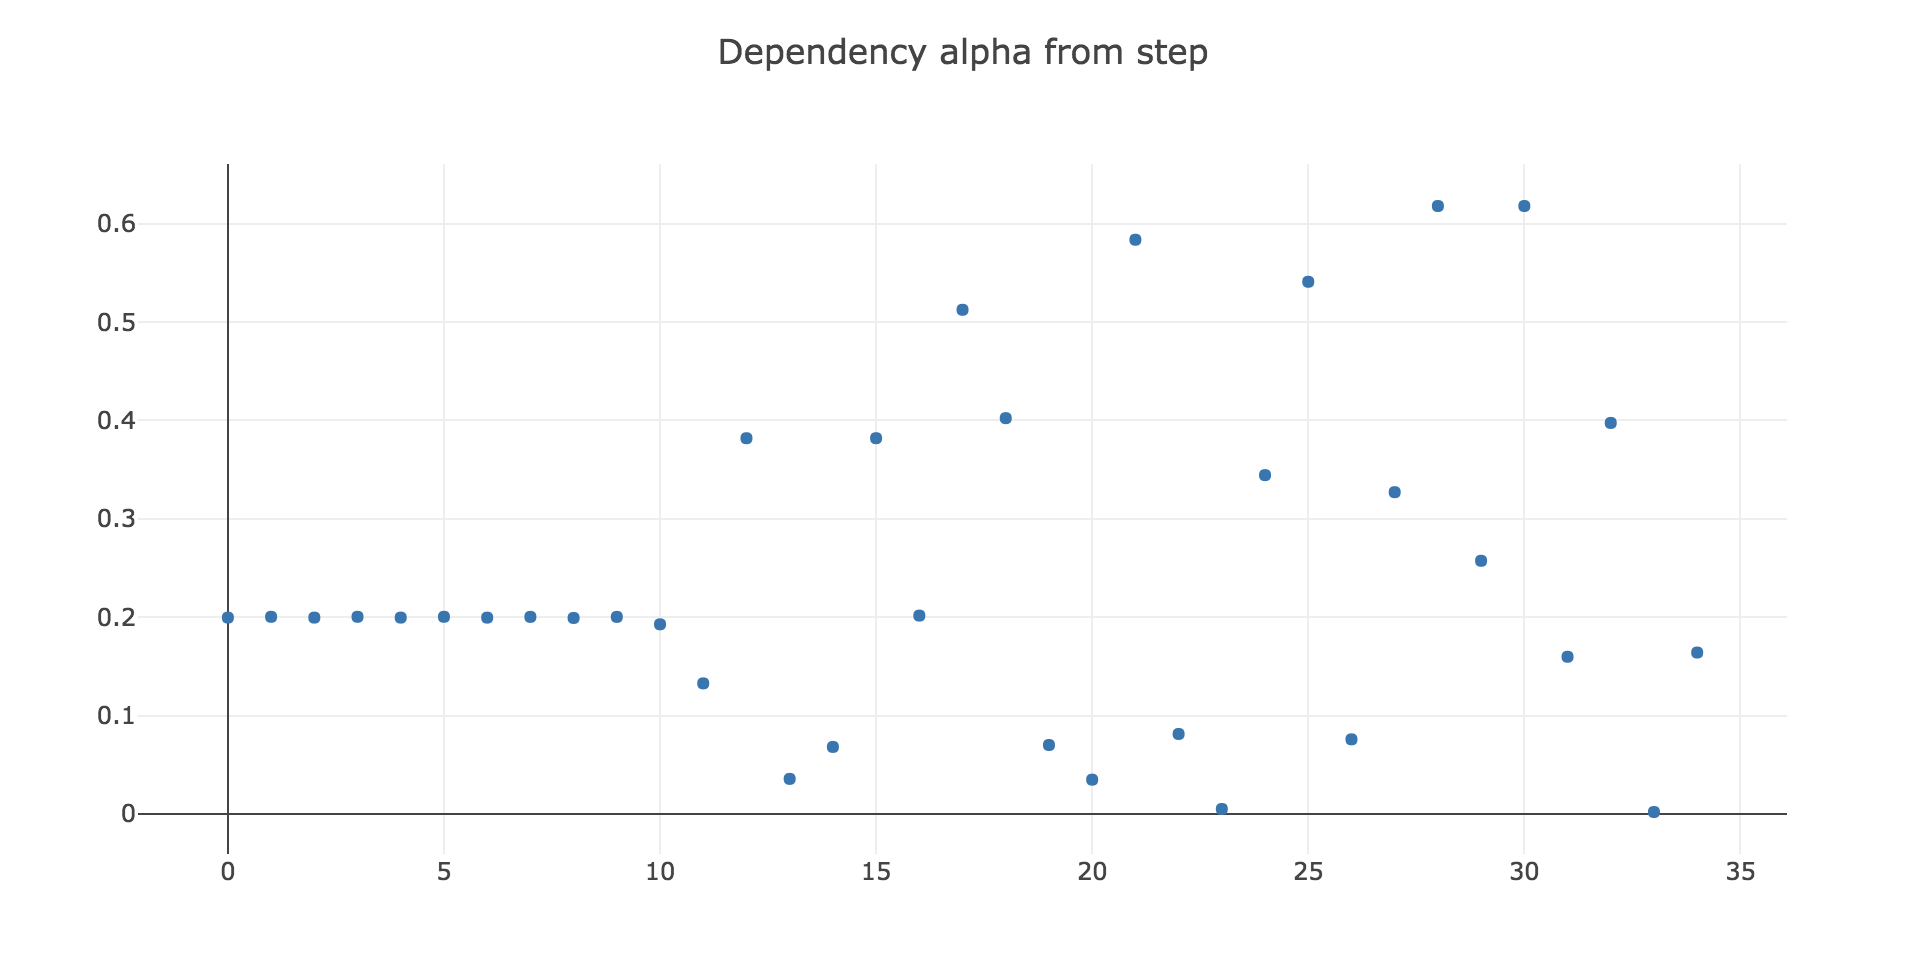

In [13]:
Image('image/grad_fast_descent.png')